In [1]:
from Modular_code.utils import *
from Modular_code.clr import OneCycle
from Modular_code.radam import RAdam
from Modular_code.opts import *

In [2]:
import pandas as pd
train_label = pd.read_csv(train_label_path)
valid_label = pd.read_csv(valid_label_path)
test_label = pd.read_csv(test_label_path)

In [3]:
train_id,train_classes = create_label(train_label,'./DataSet/Train') 
test_id,test_classes = create_label(test_label,'./DataSet/Test') 
valid_id,valid_classes = create_label(valid_label,'./DataSet/Validation') 

In [4]:
def extract_label(id,classes):
    id_new0 = []
    id_new1 = []
    for i,j in enumerate(classes):
        if(j == 0):
            id_new0.append(id[i])
        if(j == 1):
            id_new1.append(id[i])
    return id_new0,id_new1

In [5]:
train_id0,train_id1 = extract_label(train_id,train_classes)
import numpy as np
train_id = train_id + 5*train_id0 + 1*train_id1
train_classes = train_classes + np.zeros(len(5*train_id0),dtype = int).tolist() + np.ones(len(1*train_id1) , dtype = int).tolist()

In [6]:
from collections import Counter

print(Counter(train_classes).keys()) # equals to list(set(words))
Counter(train_classes).values()

dict_keys([2, 3, 1, 0])


dict_values([2615, 2493, 426, 204])

In [7]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import os
import numpy as np
import cv2
im_size = 112
class video_dataset(Dataset):
    def __init__(self,id,label,sequence_length = 60,transform = None):
        self.id =id
        self.engagement = label
        self.transform = transform
        self.count = sequence_length
    def __len__(self):
        return len(self.id)
    def __getitem__(self,idx):
        video_path = self.id[idx]
        frames = []
        a = int(300/self.count)
        hp = np.random.randint(0,2)
        id1 = np.random.randint(0,a)
        label = self.engagement[idx]
        for i,frame in enumerate(frame_extract(video_path)):
            if(i % a == id1):
                if(label < 2):
                    if(hp == 1):
                        frame = cv2.flip(frame,1)
                frames.append(self.transform(frame))
        frames = torch.stack(frames)
        #frames = frames[::a,:,:,:]
        frames = frames[:self.count]
#        frames = frames.permute(1,0,2,3)
        return frames,label

In [27]:
im_size = 112
train_transforms = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.Resize((im_size,im_size)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)])
test_transforms = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.Resize((im_size,im_size)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)])
train_data = video_dataset(train_id,train_classes,sequence_length = 150,transform = train_transforms)
val_data = video_dataset(valid_id,valid_classes,sequence_length = 150,transform = train_transforms)
test_data = video_dataset(test_id,test_classes,sequence_length = 150,transform = train_transforms)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


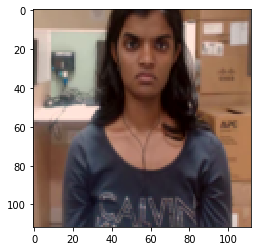

In [33]:
import cv2
import random
image,_ = train_data[1000]
im_plot(image[100,:,:,:])

In [29]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import numpy as np
from torch.autograd import Variable
from torchvision.models import resnet152
from efficientnet_pytorch import EfficientNet
##############################
#         Encoder
##############################

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        resnet = EfficientNet.from_pretrained('efficientnet-b0')
        resnet._fc = Identity()
        for param in resnet.parameters():
            param.requires_grad = False
        self.resnet = resnet
        self.bn1 = nn.BatchNorm1d(1280, momentum=0.01)
        #self.final = nn.Sequential(nn.Linear(1280, latent_dim), nn.BatchNorm1d(latent_dim, momentum=0.01))        
    def forward(self, x):
        x = self.resnet(x)
        x = x.view(x.size(0), -1)
        return x

##############################
#           LSTM
##############################

class LSTM(nn.Module):
    def __init__(self, latent_dim, num_layers, hidden_dim, bidirectional):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(latent_dim, hidden_dim, num_layers, batch_first=True, bidirectional=bidirectional)
        self.hidden_state = None

    def reset_hidden_state(self):
        self.hidden_state = torch.randn(150, 2, 1024)
    def forward(self, x):
        self.lstm.flatten_parameters()
        x, self.hidden_state = self.lstm(x, self.hidden_state)
        return x


##############################
#      Attention Module
##############################


class Attention(nn.Module):
    def __init__(self, latent_dim, hidden_dim, attention_dim):
        super(Attention, self).__init__()
        self.latent_attention = nn.Linear(latent_dim, attention_dim)
        self.hidden_attention = nn.Linear(2*hidden_dim, attention_dim)
        self.joint_attention = nn.Linear(2*attention_dim, 1)
        self.relu = Swish()
    def forward(self, latent_repr, hidden_repr):
        if hidden_repr is None:
            hidden_repr = [
                Variable(
                    torch.zeros(latent_repr.size(0), 1, self.hidden_attention.in_features), requires_grad=False
                ).float()
            ]

        latent_att = self.latent_attention(latent_repr)
        hidden_att = self.hidden_attention(hidden_repr)
        att = self.relu(torch.cat([latent_att,hidden_att],dim = 1))
        joint_att = self.joint_attention(att)
        attention_w = F.softmax(joint_att, dim=-1)
        return attention_w


##############################
#         ConvLSTM
##############################


class ConvLSTM(nn.Module):
    def __init__(
        self, num_classes, latent_dim=512, lstm_layers=1, hidden_dim=1024, bidirectional=True, attention=True
    ):
        super(ConvLSTM, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.lstm = LSTM(latent_dim, lstm_layers, hidden_dim, bidirectional)
        self.output_layers = nn.Sequential(
            nn.Linear(2 * hidden_dim if bidirectional else hidden_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, num_classes),
        )
        self.attention = attention
        self.attention_layer = Attention(512,1024,128)
        
    def forward(self, x):
        batch_size, seq_length, c, h, w = x.shape
        x = x.view(batch_size * seq_length, c, h, w)
        x1 = self.encoder(x)
        x = x1.view(batch_size, seq_length, -1)
        x = self.lstm(x)
        if self.attention:
            attention_w = self.attention_layer(x1,x.reshape(-1,2048))
            attention_w = attention_w.reshape(-1,150)
            x = torch.sum(attention_w.unsqueeze(-1)*x, dim = 1)
        else:
            x = x[:, -1]
        return self.output_layers(x)

In [11]:
class FAN(nn.Module):
    def __init__(
        self, num_classes,latent_dim=1792, lstm_layers=1, hidden_dim=1024, bidirectional=True):
        super(FAN, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.lstm = LSTM(latent_dim, lstm_layers, hidden_dim, bidirectional)
        self.relu = Swish()
        self.attention1 = nn.Linear(1792,1)
        self.sig = nn.Sigmoid()
        self.attention2 = nn.Linear(1792*2,1)
        self.dp = nn.Dropout(0.2)
        self.output_layers = nn.Sequential(
            nn.Linear(1792*2, 1024),
            Swish(),
            nn.Dropout(0.2),
            nn.Linear(1024, num_classes))
    def forward(self, x , p = None):
        batch_size, seq_length, c, h, w = x.shape
        x = x.view(batch_size * seq_length, c, h, w).detach()
        x = self.encoder(x)
        v1 = []
        v2 = []
        x = x.view(batch_size,150,1792).detach()
        for i in range(x.shape[0]):
            alpha = self.sig(self.attention1(self.dp(x[i])))
            x1 = torch.sum(x[i]*alpha,dim = 0)
            with torch.no_grad():
                x1 = x1.unsqueeze(dim = 0).repeat(150,1)
                x2 = torch.cat([x[i],x1],dim = 1)
            betas = self.sig(self.attention2(self.dp(x2)))
            a1 = torch.sum(alpha , dim = 0)
            a2 = torch.sum(alpha*betas, dim = 0)
            x2 = torch.sum(x2*alpha*betas,dim = 0)
            v1.append(torch.div(x1,a1))
            v2.append(torch.div(x2,a2))
        v1 = torch.stack(v1)
        v2 = torch.stack(v2)
        #print(v2.shape)
        x = torch.cat([v1,v2],dim = 1)
        return self.output_layers(v2)

In [51]:
class FAN(nn.Module):
    def __init__(
        self, num_classes,latent_dim=1792, lstm_layers=1, hidden_dim=1024, bidirectional=True):
        super(FAN, self).__init__()
        self.encoder = Encoder()
        self.lstm = LSTM(latent_dim, lstm_layers, hidden_dim, bidirectional)
        self.relu = Swish()
        self.attention1 = nn.Linear(1792,1)
        self.sig = nn.Sigmoid()
        self.attention2 = nn.Linear(2048,1)
        self.dp = nn.Dropout(0.5)
        self.output_layers = nn.Sequential(
            nn.Linear(1792 + 2048, 1024),
            Swish(),
            nn.Dropout(0.6),
            nn.Linear(1024, num_classes),
            nn.Dropout(0.6))
    def forward(self, x):
        batch_size, seq_length, c, h, w = x.shape
        x = x.view(batch_size * seq_length, c, h, w).detach()
        x = self.encoder(x)
        v1 = []
        v2 = []
        x = x.view(batch_size,150,1792).detach()
        x_lstm = self.lstm(x)
        for i in range(x.shape[0]):
            alpha = self.sig(self.attention1(self.dp(x[i])))
            alpha1 = self.sig(self.attention2(self.dp(x_lstm[i])))
            x1 = torch.sum(x[i]*alpha,dim = 0)
            x2 = torch.sum(x_lstm[i]*alpha1,dim = 0)
            a1 = torch.sum(alpha , dim = 0)
            a2 = torch.sum(alpha1, dim = 0)
            v1.append(torch.div(x1,a1))
            v2.append(torch.div(x2,a2))
        v1 = torch.stack(v1)
        v2 = torch.stack(v2)
        x = torch.cat([v1,v2],dim = 1)
        return self.output_layers(x)

In [30]:
class FAN(nn.Module):
    def __init__(
        self, num_classes,latent_dim= 1280, lstm_layers=1, hidden_dim=1024, bidirectional = False):
        super(FAN, self).__init__()
        self.encoder = Encoder()
        self.lstm = LSTM(latent_dim, lstm_layers, hidden_dim, bidirectional)
        self.lstm1 = LSTM(1024, lstm_layers, 2048, bidirectional)
        
        self.relu = Swish()
        self.attention1 = nn.Linear(latent_dim,1)
        self.sig = nn.Sigmoid()
        self.attention2 = nn.Linear(1024*2,1)
#        self.attention4 = nn.Linear(1024*2,1)
        
        self.attention3 = nn.Linear(latent_dim*2,1)
        self.bn1 = nn.BatchNorm1d(latent_dim*2, momentum=0.01)
        self.bn2 = nn.BatchNorm1d(1024*2, momentum=0.01)
        
        self.dp = nn.Dropout(0.4)
        self.output_layers1 = nn.Sequential(
            nn.Linear(latent_dim*2, 1024),
            Swish(),
            nn.Dropout(0.5),
            nn.Linear(1024, num_classes),nn.Dropout(0.2))
        self.output_layers2 = nn.Sequential(
            nn.Linear(1024*2, num_classes),nn.Dropout(0.2))
    def forward(self, x):
        batch_size, seq_length, c, h, w = x.shape
        x = x.view(batch_size * seq_length, c, h, w).detach()
        x = self.encoder(x)
        v1 = []
        v2 = []
        v3 = []
        x = x.view(batch_size,seq_length,1280).detach()
        x_lstm = self.lstm(x)
        x_lstm = self.lstm1(x_lstm)
        for i in range(x.shape[0]):
            alpha = self.sig(self.attention1(self.dp(x[i])))
            alpha1 = self.sig(self.attention2(self.dp(x_lstm[i])))
            x1 = torch.sum(x[i]*alpha,dim = 0)
            with torch.no_grad():
                x11 = x1.unsqueeze(dim = 0).repeat(seq_length,1)
                x3 = torch.cat([x[i],x11],dim = 1)
            betas = self.sig(self.attention3(self.dp(x3)))
            x2 = torch.sum(x_lstm[i]*alpha1,dim = 0)
            x3 = torch.sum(x3*alpha*betas,dim = 0)
            a1 = torch.sum(alpha , dim = 0)
            a2 = torch.sum(alpha1, dim = 0)
            a3 = torch.sum(alpha*betas, dim = 0)
           # v1.append(torch.div(x1,a1))
            v2.append(torch.div(x2,a2))
            v3.append(torch.div(x3,a3))

#        v1 = torch.stack(v1)
        v2 = self.bn2(torch.stack(v2))
        v3 = self.bn1(torch.stack(v3))
        x1 = self.output_layers1(v3)
        x2 = self.output_layers2(v2)
        out = (x1+x2)/2
#        x = torch.cat([v2,v3],dim = 1)
        return x1,x2


In [31]:
model = FAN(4).cuda()
model = nn.DataParallel(model)
'''model_dict = model.state_dict()
pretrained_dict = torch.load('./results/FAN/save.pth')['state_dict']
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
model_dict.update(pretrained_dict)
model.load_state_dict(model_dict)'''
im_size = 112
#model.load_state_dict(torch.load('./results/FAN/save.pth')['state_dict'])
model(torch.from_numpy(np.empty((8,150,3,im_size,im_size))).type(torch.cuda.FloatTensor))[0].shape

Loaded pretrained weights for efficientnet-b0


torch.Size([8, 4])

In [7]:
class ConvLSTM(nn.Module):
    def __init__(
        self, num_classes, latent_dim=512, lstm_layers=1, hidden_dim=1024, bidirectional=True, attention=True):
        super(ConvLSTM, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.lstm = LSTM(latent_dim, lstm_layers, hidden_dim, bidirectional)
        
        self.relu = Swish()
        self.output_layers = nn.Sequential(
            nn.Linear(2 * hidden_dim if bidirectional else hidden_dim, 512),
            Swish(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes),
            nn.Dropout(0.5))
        self.attention = attention
        self.attention_layer1 = nn.Linear(1792, 256)
        self.attention_layer2 = nn.Linear(2048,256)
        self.joint_att = nn.Linear(512,1)
        self.soft = nn.Sigmoid()
    def forward(self, x , p = None):
        batch_size, seq_length, c, h, w = x.shape
        x = x.view(batch_size * seq_length, c, h, w)
        x = self.encoder(x)
        x = x.view(batch_size, seq_length, -1)
        attention_w = self.relu(self.attention_layer1(x).squeeze(-1))
#        a = torch.argsort(attention_w,dim =1)
#        a = a[:,:50]
#        if(p):
#            print(attention_w[0])
#        with torch.no_grad():
#            x1 = []
#            for i in range(len(x)):
#                x1.append(torch.index_select(x[i],0,a[i]))
#            x1 = torch.stack(x1)
        x = self.lstm(x)
        attention_w1 = self.relu(self.attention_layer2(x).squeeze(-1))
        a = torch.cat([attention_w1,attention_w],dim = 2)
        att = self.soft(self.joint_att(a).squeeze(-1))
        x = torch.mean(x*att.unsqueeze(-1),dim = 1)
        return self.output_layers(x)

In [22]:
model = ConvLSTM(
        num_classes=4,
        latent_dim=1792,
        lstm_layers=1,
        hidden_dim=1024,
        bidirectional=True,
        attention=True,
    ).cuda()
model = nn.DataParallel(model)
#model.load_state_dict(torch.load('./results/cnnlstm-effb0-224-attention-sig/save.pth')['state_dict'])

Loaded pretrained weights for efficientnet-b4


In [51]:
im_size = 112
model(torch.from_numpy(np.empty((8,150,3,im_size,im_size))).type(torch.cuda.FloatTensor)).shape

torch.Size([8, 4])

In [13]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
    def forward(self, x):
        return x
from torchvision import models

from efficientnet_pytorch import EfficientNet
class SwishImplementation(torch.autograd.Function):
    @staticmethod
    def forward(ctx, i):
        result = i * torch.sigmoid(i)
        ctx.save_for_backward(i)
        return result

    @staticmethod
    def backward(ctx, grad_output):
        i = ctx.saved_variables[0]
        sigmoid_i = torch.sigmoid(i)
        return grad_output * (sigmoid_i * (1 + i * (1 - sigmoid_i)))


class Swish(nn.Module):
    @staticmethod
    def forward(x):
        return SwishImplementation.apply(x)

In [8]:
from torchvision import models

from efficientnet_pytorch import EfficientNet
class SwishImplementation(torch.autograd.Function):
    @staticmethod
    def forward(ctx, i):
        result = i * torch.sigmoid(i)
        ctx.save_for_backward(i)
        return result

    @staticmethod
    def backward(ctx, grad_output):
        i = ctx.saved_variables[0]
        sigmoid_i = torch.sigmoid(i)
        return grad_output * (sigmoid_i * (1 + i * (1 - sigmoid_i)))


class Swish(nn.Module):
    @staticmethod
    def forward(x):
        return SwishImplementation.apply(x)
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        model = EfficientNet.from_pretrained('efficientnet-b1')
        model._fc = Identity()
        for param in model.parameters():
            param.requires_grad = False
        self.model1 = model
        self.lstm = nn.LSTM(1280,1024,1,batch_first=True ,dropout = 0.5 , bidirectional = True)
        self.l1 = nn.Linear(2048,512)
        self.dp = nn.Dropout(0.4)
        self.relu = Swish()
        self.l2 = nn.Linear(512,4)
    def forward(self,x):
        self.lstm.flatten_parameters()
        out = self.model1(x)
#        print(out.shape)
        out1 = out.view(-1,150,1280).detach()
        out,_ = self.lstm(out1,None)
        out = torch.mean(out,dim=1)
        out = self.dp(self.relu(self.l1(out)))
        out = self.l2(out)
        return out
model = Model().cuda()
model = nn.DataParallel(model)
model.load_state_dict(torch.load('./results/lrcn-effb4-224/save.pth')['state_dict'])

Loaded pretrained weights for efficientnet-b1


/home/sanjaymoto75/.conda/envs/env/lib/python3.7/site-packages/torch/nn/modules/rnn.py:51: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


<All keys matched successfully>

In [30]:
import numpy as np
im_size = 112
model(torch.from_numpy(np.empty((600,3,im_size,im_size))).type(torch.cuda.FloatTensor))

tensor([[ 0.0312,  0.0350, -0.0293,  0.0418],
        [ 0.0340,  0.0345, -0.0242,  0.0434],
        [ 0.0245,  0.0262, -0.0234,  0.0406],
        [ 0.0267,  0.0314, -0.0220,  0.0394]], device='cuda:0',
       grad_fn=<GatherBackward>)

In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)
        logpt = F.log_softmax(input)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())
        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)
        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()

In [ ]:
import torch
from torch.autograd import Variable
import time
import os
import sys
import os
def train_epoch(epoch, num_epochs, data_loader, model, criterion, optimizer, epoch_logger, batch_logger, batch_size , onecyc , writer , result_path):
    print('Training Epoch {}'.format(epoch))
    model.train()
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    accuracies = AverageMeter()
    accuracies_att = AverageMeter()
    accuracies_lstm = AverageMeter()
    
    start_time = time.time()
    end_time = time.time()
    flag = 0
    for i, (inputs, targets) in enumerate(data_loader):
        data_time.update(time.time() - end_time)
        if(inputs.size(0)<batch_size):
            continue
        if torch.cuda.is_available():
            targets = targets.cuda()
            inputs = inputs.cuda()
        #with torch.no_grad():
        #    inputs = inputs.reshape(-1,3,im_size,im_size)
        x1,x2 = model(inputs)
        outputs = (x1+x2)/2
        #outputs = torch.mul(outputs,class_weights)
        #loss1 = CB_loss(targets, x1, samples_per_cls,no_of_classes,loss_type, beta, gamma)
        #loss2 = CB_loss(targets, x2, samples_per_cls,no_of_classes,loss_type, beta, gamma)
        loss = criterion(outputs, targets)
        acc = calculate_accuracy(outputs, targets)
        acc_att = calculate_accuracy(x1, targets)
        acc_lstm = calculate_accuracy(x2, targets)
        #loss2.backward()
        
        accuracies_att.update(acc_att, inputs.size(0))
        accuracies_lstm.update(acc_lstm, inputs.size(0))
        losses.update(loss.item(), inputs.size(0))
        accuracies.update(acc, inputs.size(0))
        lr,_ = onecyc.calc()
        update_lr(optimizer, lr)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_time.update(time.time() - end_time)
        end_time = time.time()
        del inputs,targets,outputs
        torch.cuda.empty_cache() 
    
        batch_logger.log({
            'epoch': epoch,
            'batch': i + 1,
            'iter': (epoch - 1) * len(data_loader) + (i + 1),
            'loss': losses.val,
            'acc': accuracies.val,
            'lr': optimizer.param_groups[0]['lr']
        })
        writer.add_scalar('data/acc', accuracies.val, (epoch - 1) * len(data_loader) + (i + 1))
        writer.add_scalar('data/loss', losses.val, (epoch - 1) * len(data_loader) + (i + 1))        
        sys.stdout.write(
                "\r[Epoch %d/%d] [Batch %d / %d] [Time %.2f %.2f] [Data %.2f %.2f] [Loss: %f, Acc: %.2f%% , att: %.2f%% , lstm: %.2f%%]"
                % (
                    epoch,
                    num_epochs,
                    i,
                    len(data_loader),
                    batch_time.val,
                    batch_time.avg,
                    data_time.val,
                    data_time.avg,
                    losses.avg,
                    accuracies.avg,
                    accuracies_att.avg,
                    accuracies_lstm.avg
                    
                    )
                )
    print('\nEpoch time {} mins'.format((end_time-start_time)/60))
    epoch_logger.log({
        'epoch': epoch,
        'loss': losses.avg,
        'acc': accuracies.avg,
        'lr': optimizer.param_groups[0]['lr']
    })
    writer.add_scalar('data/acc_epoch', accuracies.avg, epoch)
    writer.add_scalar('data/loss_epoch', losses.avg, epoch)        
    torch.cuda.empty_cache() 
    save_file_path = os.path.join(result_path,'save.pth')
    states = {
        'model':model.module,
        'state_dict': model.state_dict()
    }
    torch.save(states, save_file_path)

def test(epoch,model, data_loader ,criterion, batch_size, result_path,best_acc = 0 , logger = None ):
    print('Testing')
    if(epoch == 1):
        best_acc = 0
    model.eval()
    losses = AverageMeter()
    accuracies = AverageMeter()
    accuracies_att = AverageMeter()
    accuracies_lstm = AverageMeter()
    pred = []
    pred_att = []
    pred_lstm = []
    true = []
    for i, (inputs, targets) in enumerate(data_loader):
        if(inputs.size(0)<batch_size):
            continue
        if torch.cuda.is_available():
            targets = targets.cuda()
            inputs = inputs.cuda()
        inputs = Variable(inputs)
        #with torch.no_grad():
        #    inputs = inputs.reshape(-1,3,im_size,im_size)
        targets = Variable(targets)
        x1,x2 = model(inputs)
        outputs = (x1+x2)/2
        #outputs = torch.mul(outputs,class_weights)
        _,p = torch.max(outputs,1)
        _,p_att = torch.max(x1,1)
        _,p_lstm = torch.max(x2,1)
        #loss = CB_loss(targets, outputs, samples_per_cls, no_of_classes,loss_type, beta, gamma)
        loss = criterion(outputs, targets)
        acc = calculate_accuracy(outputs, targets)
        acc_att = calculate_accuracy(x1, targets)
        acc_lstm = calculate_accuracy(x2, targets)
        true += targets.detach().cpu().numpy().reshape(len(targets)).tolist()
        pred += p.detach().cpu().numpy().reshape(len(p)).tolist()
        pred_att += p_att.detach().cpu().numpy().reshape(len(p_att)).tolist()
        pred_lstm += p_lstm.detach().cpu().numpy().reshape(len(p_lstm)).tolist()
        
        losses.update(loss.item(), inputs.size(0))
        accuracies.update(acc, inputs.size(0))
        accuracies_att.update(acc_att, inputs.size(0))
        accuracies_lstm.update(acc_lstm, inputs.size(0))
        del inputs,targets,outputs
        torch.cuda.empty_cache() 
        
        sys.stdout.write(
                "\r[Batch %d / %d]  [Loss: %f, Acc: %.2f%% , att: %.2f%% , lstm: %.2f%%]"
                % (
                    i,
                    len(data_loader),
                    losses.avg,
                    accuracies.avg,
                    accuracies_att.avg,
                    accuracies_lstm.avg
                    )
                )
    if(logger):
        logger.log({'epoch': epoch, 'loss': losses.avg, 'acc': accuracies.avg})
    print('\nAccuracy {}'.format(accuracies.avg))
    if(accuracies.avg>best_acc):
        best_acc = accuracies.avg
        result_path = os.path.join(result_path,'best.pth')
        state = {
        'acc':best_acc,
         'state':model.state_dict()
        }
        torch.save(state,result_path)
    return true,pred,pred_att,pred_lstm

In [20]:
arch = 'FAN'
result_path = os.path.join('./results',arch)
from tensorboardX import SummaryWriter
writer = SummaryWriter()
os.makedirs(result_path,exist_ok = True)
train_logger = Logger(
            os.path.join(result_path, 'train{}.log'.format(arch)),
            ['epoch', 'loss', 'acc', 'lr'])
train_batch_logger = Logger(
            os.path.join(result_path, 'train_batch{}.log'.format(arch)),
            ['epoch', 'batch', 'iter', 'loss', 'acc', 'lr'])    
val_logger = Logger(
            os.path.join(result_path, 'val{}.log'.format(arch)), ['epoch', 'loss', 'acc'])

In [22]:
batch_size = 8
train_loader = DataLoader(train_data,batch_size = batch_size , num_workers = 8,shuffle = True)
val_loader = DataLoader(val_data,batch_size = batch_size , num_workers = 8)
test_loader = DataLoader(test_data,batch_size = batch_size , num_workers = 8)

In [21]:
def set_lr(optimizer, lr):
    for group in optimizer.param_groups:
        group['lr'] = lr

In [22]:
import numpy as np
import torch
import torch.nn.functional as F

def focal_loss(labels, logits, alpha, gamma):
    """Compute the focal loss between `logits` and the ground truth `labels`.
    Focal loss = -alpha_t * (1-pt)^gamma * log(pt)
    where pt is the probability of being classified to the true class.
    pt = p (if true class), otherwise pt = 1 - p. p = sigmoid(logit).
    Args:
      labels: A float tensor of size [batch, num_classes].
      logits: A float tensor of size [batch, num_classes].
      alpha: A float tensor of size [batch_size]
        specifying per-example weight for balanced cross entropy.
      gamma: A float scalar modulating loss from hard and easy examples.
    Returns:
      focal_loss: A float32 scalar representing normalized total loss.
    """    
    BCLoss = F.binary_cross_entropy_with_logits(input = logits, target = labels,reduction = "none")

    if gamma == 0.0:
        modulator = 1.0
    else:
        modulator = torch.exp(-gamma * labels * logits - gamma * torch.log(1 + 
            torch.exp(-1.0 * logits)))

    loss = modulator * BCLoss
    weighted_loss = alpha * loss
    focal_loss = torch.sum(weighted_loss)

    focal_loss /= torch.sum(labels)
    return focal_loss



def CB_loss(labels, logits, samples_per_cls, no_of_classes, loss_type, beta, gamma,p = 0):
    """Compute the Class Balanced Loss between `logits` and the ground truth `labels`.
    Class Balanced Loss: ((1-beta)/(1-beta^n))*Loss(labels, logits)
    where Loss is one of the standard losses used for Neural Networks.
    Args:
      labels: A int tensor of size [batch].
      logits: A float tensor of size [batch, no_of_classes].
      samples_per_cls: A python list of size [no_of_classes].
      no_of_classes: total number of classes. int
      loss_type: string. One of "sigmoid", "focal", "softmax".
      beta: float. Hyperparameter for Class balanced loss.
      gamma: float. Hyperparameter for Focal loss.
    Returns:
      cb_loss: A float tensor representing class balanced loss
    """
    effective_num = 1.0 - np.power(beta, samples_per_cls)
    weights = (1.0 - beta) / np.array(effective_num)
    weights = weights / np.sum(weights)*4
    labels_one_hot = F.one_hot(labels, no_of_classes).float()
    weights = torch.tensor(weights).float().cuda()
    weights1 = weights
    weights = weights.unsqueeze(0)
    weights = weights.repeat(labels_one_hot.shape[0],1) * labels_one_hot
    weights = weights.sum(1)
    weights = weights.unsqueeze(1)
    weights = weights.repeat(1,no_of_classes)    
    if loss_type == "focal":
        cb_loss = focal_loss(labels_one_hot, logits, weights, gamma)
    elif loss_type == "sigmoid":
        cb_loss = F.binary_cross_entropy_with_logits(input = logits,target = labels_one_hot, weights = weights)
    elif loss_type == "softmax":
        pred = logits.softmax(dim = 1)
        if(p == 1):
            pass
            #print(pred,labels_one_hot)
        cb_loss = F.binary_cross_entropy(input = pred, target = labels_one_hot, weight = weights1)
    return cb_loss


In [ ]:
from sklearn.metrics import confusion_matrix
lr = 1e-3
batch_size = 32
train_loader = DataLoader(train_data,batch_size = batch_size , num_workers = 16,shuffle = True)
val_loader = DataLoader(val_data,batch_size = batch_size , num_workers = 16)
test_loader = DataLoader(test_data,batch_size = batch_size , num_workers = 16)
class_weights = torch.from_numpy(np.asarray([2, 1, 0.21102427, 0.22006205])).type(torch.FloatTensor).cuda()
#optimizer = torch.optim.SGD(model.parameters() , lr = lr , momentum = 0.9 , weight_decay = 1e-3)
optimizer = RAdam(model.parameters(), lr= lr,weight_decay = 1e-4)
onecyc = OneCycle(len(train_loader)*num_epochs, lr)
#criterion = nn.CrossEntropyLoss(weight = class_weights).cuda()
#criterion = nn.CrossEntropyLoss().cuda()

criterion = FocalLoss(gamma = 3).cuda()
best_acc = 0
beta = 0.9999
gamma = 0.5
no_of_classes = 4
samples_per_cls = [204,426,2615,2493]
loss_type = "focal"
num_epochs = 10
for epoch in range(1,num_epochs+1):
    train_epoch(epoch,num_epochs,train_loader,model,criterion,optimizer,train_logger,train_batch_logger,batch_size,onecyc,writer,result_path)
    true,pred,pred_att,pred_lstm = test(epoch,model,val_loader,criterion,batch_size,result_path,best_acc)
    cm1 = confusion_matrix(true,pred)
    cm2 = confusion_matrix(true,pred_att)
    cm3 = confusion_matrix(true,pred_lstm)
    print('Comb\n',cm1 ,'Att\n\n' ,cm2,'Lstm\n\n' , cm3)
    if(epoch%5 == 0):
        true,pred,pred_att,pred_lstm = test(epoch,model,test_loader,criterion,batch_size,result_path,best_acc)
        cm1 = confusion_matrix(true,pred)
        cm2 = confusion_matrix(true,pred_att)
        cm3 = confusion_matrix(true,pred_lstm)
        print('Comb\n',cm1 ,'Att\n\n' ,cm2,'Lstm\n\n' , cm3)
